In [1]:
from bs4 import BeautifulSoup
import lxml
from pathlib import Path
import os
import pandas as pd
import re
import sys
from doc import Doc, standardizeWord, standardizeChar
from io import StringIO

import itertools
import numpy as np
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# import model classes
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split

c:\users\maste\envs\envtest\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
names = ['word count','sentence count','sentence length','lemma ratio','p95','mean','median','noun','verb','prep','part','conj','adv','adj','word length','difficulty']
dir = 'C:\\Users\\maste\\Desktop\\RAFT\\arabicScraperOutput'
docs = {}

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [11]:
#get frequency data
freqFile = open('frequencyList.txt', "r", encoding="utf8")
freqList = freqFile.read()
freqFile.close()
freqLines = freqList.split("\n")
frequencies = {}
for line in freqLines:
    if (line != ''):
        data = line.split(":::")
        lemma = standardizeWord(data[1])
        pos = data[2]
        freq = data[0]
        frequencies[lemma+":::"+pos] = freq
freqSeries = pd.Series(frequencies, dtype='int')
freqSeries = freqSeries.sort_values(ascending=False)
#print(freqSeries)

In [12]:
#create the data file
fout = open("arabicReading.data", "w+",encoding='utf8')
fileCount = 0
for filename in os.listdir(dir):
    numFiles =  numFiles = len(os.listdir(dir))
    if os.path.isfile(dir+"\\frequency_list\\"+filename):
        doc = Doc(dir,filename)
        docs[filename]=doc
        df = doc.frequencyTable
        for line in doc.lemmaList:
            count = doc.lemmaList[line]
            key = doc.getKeyFromLemmaListLine(line)
            if key != '':
                p = key.split(":::")
                lemma = p[0]
                pos = p[1]
                if key != '' and key in freqSeries.index:
                    freq = freqSeries.index.get_loc(key)+1
                    for i in range(0,count):
                        ndf = pd.DataFrame([[lemma,pos,freq]],columns=['lemma','pos','freq']);
                        df = df.append(ndf)
        df.freq = df.freq.astype('int')
        doc.frequencyTable = df
        doc.getFrequencyInfo()
        #print(len(doc.lemmaList))
        #print(doc.frequencyTable.sort_values(by=['freq'],ascending=False))
        #print(filename,doc.getDataString())
        sys.stdout.write("\r %i%% processed" % (fileCount/numFiles * 100))
        sys.stdout.flush()
        fout.write(doc.getDataString()+"\n")
    fileCount += 1
fout.close()
print('')
print('finished')

 99% processed
finished


In [13]:
#create the pandas data frame
data = pd.DataFrame(columns = names)
for name in docs:
    d = docs[name]
    TESTDATA = StringIO(d.getDataString())
    df = pd.read_csv(TESTDATA,header=None,names=names,dtype='float64')
    data=data.append(df)
data.to_csv(path_or_buf='trainingData.csv')

In [3]:
data = pd.read_csv('trainingData.csv',header=None,names=names,dtype='float64')
print(len(data['difficulty'].index))

888


In [4]:
X = data.as_matrix()
y = data['difficulty'].as_matrix()
class_names = ['1', '2', '3', '4', '5']
print(len(X))

888


c:\users\maste\envs\envtest\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
c:\users\maste\envs\envtest\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
# X_train = X
# X_test = X
# y_train = y
# y_test = y
classifier = RandomForestClassifier()
y_pred = classifier.fit(X_train, y_train).predict(X_test)

Confusion matrix, without normalization
[[ 38   0   0   0]
 [  0 124   0   0]
 [  0   7  49   0]
 [  0   0   0   4]]
Normalized confusion matrix
[[1.   0.   0.   0.  ]
 [0.   1.   0.   0.  ]
 [0.   0.12 0.88 0.  ]
 [0.   0.   0.   1.  ]]


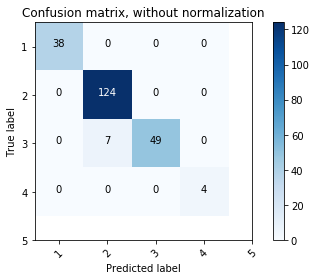

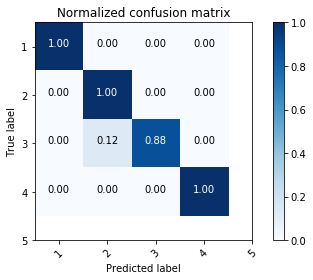

In [23]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [25]:
#init variables for machine learning
array = data.values
len_names = len(names)
features = array[:,0:len_names-1]  # comma in slice signifies a tuple (tuples in slices is a numpy array thing)
labels = array[:,-1]
validation_size = 0.10
seed = 7
feats_train, feats_validation, labels_train, labels_validation = model_selection.train_test_split(features, labels, test_size=validation_size, random_state=seed)
scoring = 'accuracy'

In [28]:
#learn!
print('Initializing models...')
# Spot Check Algorithms
models = [('LR', LogisticRegression()),
          ('LDA', LinearDiscriminantAnalysis()),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier()),
          ('NB', GaussianNB()),
          ('SVM', SVC()),
          ('RF',RandomForestClassifier())]
print('Training and testing each model using 10-fold cross-validation...')
# https://chrisjmccormick.files.wordpress.com/2013/07/10_fold_cv.png
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.StratifiedKFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, feats_train, labels_train,
                                                 cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = '{}:\t{:.4f}\t({:.4f})'.format(name, cv_results.mean(),
                                         cv_results.std())
    print(msg)

Initializing models...
Training and testing each model using 10-fold cross-validation...
LR:	0.6948	(0.0328)
KNN:	0.6319	(0.0407)
CART:	0.6212	(0.0612)
NB:	0.6310	(0.0571)
SVM:	0.6246	(0.0111)
RF:	0.6806	(0.0448)


In [11]:
cm_labels = '1 2 3 4 5'
#print(confusion_matrix(labels_validation, predictions, labels=cm_labels))

NameError: name 'predictions' is not defined

In [9]:
'''directory = 'C:\\Users\\maste\\Desktop\\RAFT\\arabicScraperOutput\\frequency_list'
missingList = {}
for filename in os.listdir(directory):
if filename.endswith('.txt'):
    myFile = os.path.join(directory, filename)
    f = open(myFile, "r", encoding="utf8")
    text = f.read()
    f.close()
    dataList = text.split('\n')
    total = 0
    missing = 0
    for line in dataList:
        if line != '':
            total += 1
            d = {}
            d = line.split(":::")
            #print(line)
            #print(d)
            pos = d[3]
            lemma = standardizeWord(d[1])
            if pos == 'conj_sub':
                pos = 'conj'
            if pos == 'part_verb':
                pos = 'part'
            if lemma == 'هل' and pos == 'part_interrog':
                pos = 'prep'
            if lemma == 'منذ' and pos == 'conj':
                pos = 'prep'
            if lemma == 'عند' and pos == 'noun':
                pos = 'prep'
            if pos != 'digit' and pos != 'noun_prop':
                key = lemma+":::"+pos
                if (key not in frequencies):
                    checkMissing = True
                    if pos == 'adj':
                        test = lemma+":::noun"
                        if test in frequencies:
                            checkMissing = False
                    missing += 1
                    if checkMissing == True:
                        if key in missingList:
                            missingList[key] += 1
                        else:
                            missingList[key] = 1
                            #print(key," does not exists")
                #print()
    #print(missing,"/",total," or ",missing/total,"%")
s = pd.Series(missingList, dtype='int')
s = s.sort_values(ascending=False)
#print(s)
   '''

'directory = \'C:\\Users\\maste\\Desktop\\RAFT\\arabicScraperOutput\\frequency_list\'\nmissingList = {}\nfor filename in os.listdir(directory):\nif filename.endswith(\'.txt\'):\n    myFile = os.path.join(directory, filename)\n    f = open(myFile, "r", encoding="utf8")\n    text = f.read()\n    f.close()\n    dataList = text.split(\'\n\')\n    total = 0\n    missing = 0\n    for line in dataList:\n        if line != \'\':\n            total += 1\n            d = {}\n            d = line.split(":::")\n            #print(line)\n            #print(d)\n            pos = d[3]\n            lemma = standardizeWord(d[1])\n            if pos == \'conj_sub\':\n                pos = \'conj\'\n            if pos == \'part_verb\':\n                pos = \'part\'\n            if lemma == \'هل\' and pos == \'part_interrog\':\n                pos = \'prep\'\n            if lemma == \'منذ\' and pos == \'conj\':\n                pos = \'prep\'\n            if lemma == \'عند\' and pos == \'noun\':\n      